In [27]:
# appliance = 'kettle'
# power = 2000

appliance = 'toaster'
power = 1200

#appliance = 'audio amplifier'
#power = 20

# appliance = 'dish washer'
# power = 2000

#appliance = 'hair dryer'
#power = 1000

#appliance = 'mmicrowave'
#power = 1500

Escolha na próxima célula se deseja escolher uma janela de tempo e o período de inicio e fim:

In [28]:
set_timewindow = False
startDate = '2013-03-01'
endDate = '2013-06-01'

In [29]:
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import nilmtk
from nilmtk import DataSet, MeterGroup
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sns.set()
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 8)
caminho_ukdale = 'ukdale.h5'

# Lendo Dataset do Ukdale
ukdale = DataSet(caminho_ukdale)

In [30]:
if set_timewindow:
    ukdale.set_window(start=startDate, end=endDate)

# Lendo eletrodomesticos da Casa 
elec = ukdale.buildings[1].elec

#Criando dataset do mains
main_df = next(elec.mains().load())
main_df.columns = [' '.join(col).strip() for col in main_df.columns.values]
main_df = main_df.rename(columns={'power apparent': 'pwr_app_mains', 'power active': 'pwr_act_mains', 'voltage': 'voltage_mains'})
main_df = main_df.sort_index()
main_df.head()

,voltage_mains,pwr_app_mains,pwr_act_mains
2013-03-17 19:12:43.100000+00:00,240.149994,431.040009,337.880005
2013-03-17 19:12:44.100000+00:00,240.559998,427.940002,339.429993
2013-03-17 19:12:45.100000+00:00,241.070007,429.660004,340.630005
2013-03-17 19:12:46.100000+00:00,240.440002,426.989990,338.799988
2013-03-17 19:12:47.100000+00:00,241.009995,429.130005,340.880005


In [31]:
appliance_df = next(elec[appliance].load())
appliance_df.columns = ['pwr_act_' + appliance]
appliance_df = appliance_df.sort_index()
appliance_df.head()

,pwr_act_toaster
2012-12-14 22:21:32+00:00,0.0
2012-12-14 22:21:38+00:00,0.0
2012-12-14 22:21:44+00:00,0.0
2012-12-14 22:21:50+00:00,0.0
2012-12-14 22:21:56+00:00,0.0


In [32]:
#-------------------Upsample do main_df--------------------------#
appliance_df = appliance_df[appliance_df.index >= main_df.index[0]]

main_df = main_df.resample('6S', base=5).mean().interpolate()
main_df = main_df[main_df.index >= main_df.index[1]]
main_df = main_df[main_df.index <= appliance_df.index[-1]]

#------------------Resampling appliance_df-----------------------#
appliance_df = appliance_df.resample('6S', base=5).mean().interpolate()

#-------------------Merging dataframes---------------------------#
merged_df = main_df.merge(appliance_df, left_index=True, right_index=True)
merged_df['time'] = merged_df.index
merged_df['time'] = merged_df['time'].apply(lambda x: x.tz_localize(None))
merged_df.index = merged_df['time']
merged_df['dia_semana'] = merged_df.time.dt.dayofweek
merged_df['mes'] = merged_df.time.dt.month
merged_df['hora'] = merged_df.time.dt.hour
merged_df['timestamp'] = merged_df['time'].apply(lambda x: x.timestamp())
merged_df = merged_df.drop(columns=['time'])

#---------------Criando coluna classificatoria-------------------#
merged_df['ligado'] = merged_df['pwr_act_' + appliance] > power

/tmp/ipykernel_5883/1500720318.py:4: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  main_df = main_df.resample('6S', base=5).mean().interpolate()
/tmp/ipykernel_5883/1500720318.py:9: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  appliance_df = appliance_df.resample('6S', base=5).mean().interpolate()


Utilize a próxima célula para inspecionar o dataframe final:

In [25]:
merged_df.tail()

,voltage_mains,pwr_app_mains,pwr_act_mains,pwr_act_dish washer,dia_semana,mes,hora,timestamp,ligado
time,,,,,,,,,
2015-01-05 06:25:11,243.346664,202.818344,173.566666,1.0,0,1,6,1.420439e+09,False
2015-01-05 06:25:17,243.433334,202.701660,173.366653,1.0,0,1,6,1.420439e+09,False
2015-01-05 06:25:23,243.541672,203.005005,173.713333,1.0,0,1,6,1.420439e+09,False
2015-01-05 06:25:29,243.293335,203.264999,173.848328,1.0,0,1,6,1.420439e+09,False
2015-01-05 06:25:35,243.388351,203.020004,173.546677,1.0,0,1,6,1.420439e+09,False


Use a próxima célula para averiguar as features

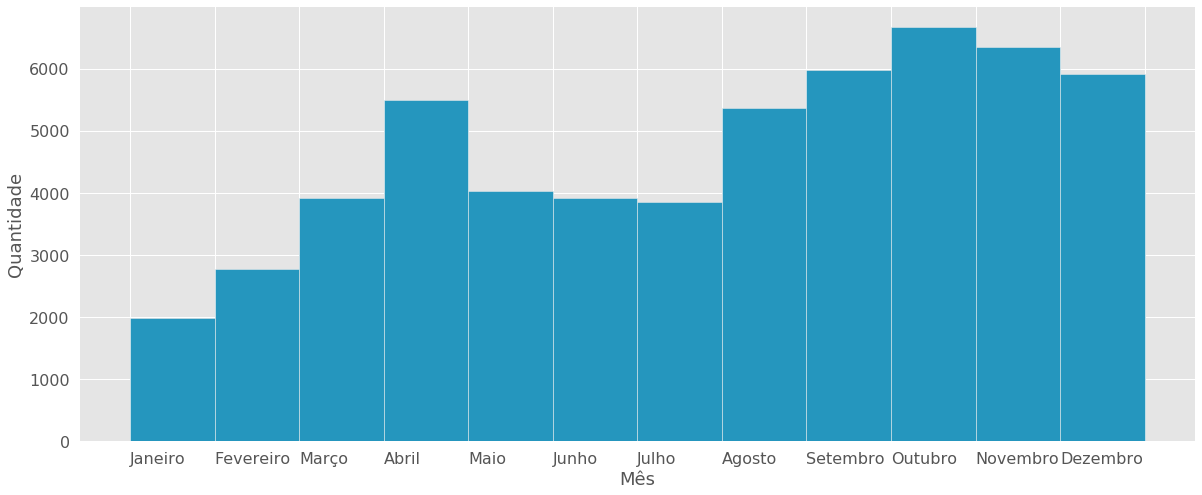

In [10]:
import matplotlib.ticker as ticker




SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)



# data = merged_df[merged_df['ligado'] == True]['dia_semana']
# nome = 'Histograma em relação ao dia da semana'
# x= np.arange(0,8)
# labels= ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado']
# plt.xlabel('Dia da Semana')

# data = merged_df[merged_df['ligado'] == True]['hora']
# nome = 'Histograma em relação à hora'
# x= np.arange(0,25)
# labels = np.arange(0,24)
# plt.xlabel('Hora')

data = merged_df[merged_df['ligado'] == True]['mes']
nome = 'Histograma em relação ao mês'
x= np.arange(1,14)
labels = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
plt.xlabel('Mês')



plt.hist(data, x, color= '#2596be')
# plt.title(label='Histograma Kettle Ligado por Dia da Semana', fontdict= {'fontsize': rcParams['axes.titlesize'],
#  'fontweight' : rcParams['axes.titleweight'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'center'})


plt.ylabel('Quantidade')
plt.xticks(x, labels, horizontalalignment='left')


plt.savefig('results/EPS/hist_mes.eps', format='eps')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f651ce46cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f651ce46d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f651ce46310>],
 'medians': [<matplotlib.lines.Line2D at 0x7f651ce4d9d0>],
 'fliers': [],
 'means': []}

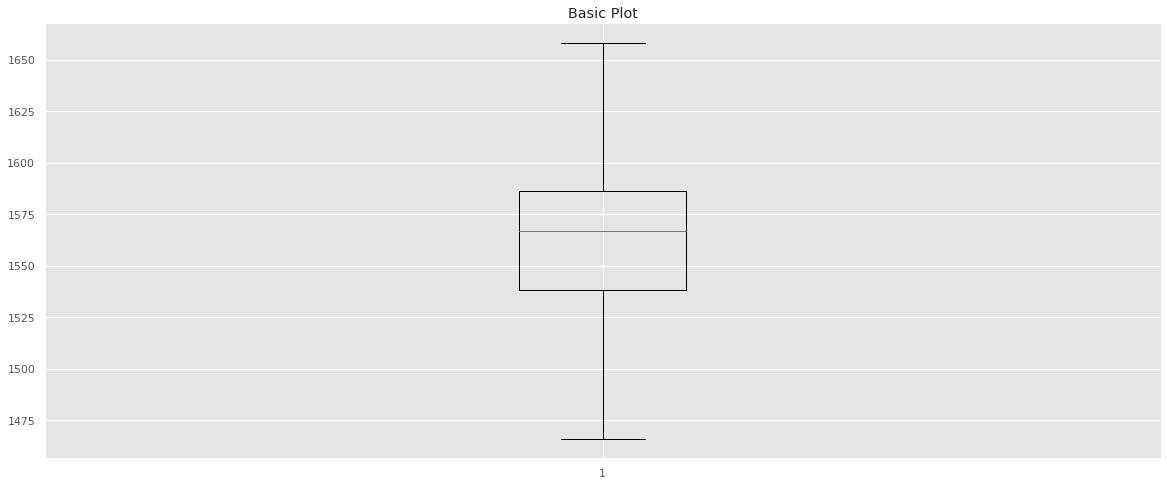

In [33]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(merged_df[merged_df['pwr_act_toaster']>500]['pwr_act_toaster'], showfliers=False)
# ax1.boxplot(merged_df['pwr_act_kettle'], showfliers=False)


# Desagregação

In [9]:
#Fazendo a divisao entre treino e teste de forma que 1 milhao de pontos sejam utilizados para treinar
train_test_divide = merged_df.index[int(0.8*len(merged_df))]

print("inicio treino: " + str(merged_df.index[0]))
print("final treino: " + str(train_test_divide))
print("final teste: " + str(merged_df.index[-1]))

inicio treino: 2013-03-17 19:12:47
final treino: 2013-05-16 23:14:29
final teste: 2013-05-31 23:59:53


In [10]:
train = merged_df[merged_df.index <= train_test_divide]
test = merged_df[merged_df.index > train_test_divide]

Utilize a próxima célula para inspecionar os dataframes de teste e treino:

In [11]:
test.head()

,pwr_app_mains,pwr_act_mains,voltage_mains,pwr_act_kettle,dia_semana,mes,hora,timestamp,ligado
time,,,,,,,,,
2013-05-16 23:14:35,236.711670,156.578339,241.266663,1.0,3,5,23,1.368746e+09,False
2013-05-16 23:14:41,236.838333,157.014999,241.913330,1.0,3,5,23,1.368746e+09,False
2013-05-16 23:14:47,236.854996,157.151672,241.968323,1.0,3,5,23,1.368746e+09,False
2013-05-16 23:14:53,237.546661,157.456665,241.888336,1.0,3,5,23,1.368746e+09,False
2013-05-16 23:14:59,237.041672,157.193329,241.853333,1.0,3,5,23,1.368746e+09,False


## Batch Size

In [12]:
train["ligado"] = train["ligado"].astype(int)
df_ligado = train[train['ligado'] == True][['ligado']].reset_index()
df_ligado['diferenca'] = df_ligado['time'].diff()
df_ligado[df_ligado['diferenca'] > '00:00:30']

<ipython-input-12-e4a9960244ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["ligado"] = train["ligado"].astype(int)


,time,ligado,diferenca
17,2013-03-18 06:57:35,1,10:10:24
37,2013-03-18 08:26:53,1,01:27:24
55,2013-03-18 11:17:29,1,02:48:54
82,2013-03-18 18:16:29,1,06:56:24
112,2013-03-18 18:34:41,1,00:15:18
...,...,...,...
5384,2013-05-16 12:08:41,1,04:14:24
5431,2013-05-16 17:06:23,1,04:53:06
5469,2013-05-16 17:19:53,1,00:09:48
5475,2013-05-16 19:52:29,1,02:32:06


In [13]:
# add a column saying if a row belongs to the same state as the one before it
df_ligado["is_first"] = df_ligado['diferenca'] > "00:00:06"

# the cumulative sum - each "clump" gets its own integer id
df_ligado["value_group"] = df_ligado["is_first"].cumsum()

# get the rows corresponding to states beginning
start = df_ligado.groupby("value_group", as_index=False).nth(0)
# get the rows corresponding to states ending
end = df_ligado.groupby("value_group", as_index=False).nth(-1)

start_end = pd.DataFrame(
    {
        "start": start.index,
        # add freq to get when the state ended
        "end": end.index,
    }
)
# convert timedeltas to seconds (float)
start_end["duration"] = (
    (start_end["end"] - start_end["start"]).apply(np.int64)
)

max(start_end.duration)

46

(array([ 5.,  4.,  7.,  3.,  1.,  5.,  3.,  4.,  4.,  7.,  4.,  5., 13.,
        15., 21., 19., 24., 19., 18., 23., 20., 20., 12., 11.,  4.,  9.,
         3.,  3.,  3.,  2.,  0.,  3.,  0.,  2.,  0.,  1.,  0.,  3.,  1.,
         1.,  0.,  0.,  2.,  0.,  1.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 45 Patch objects>)

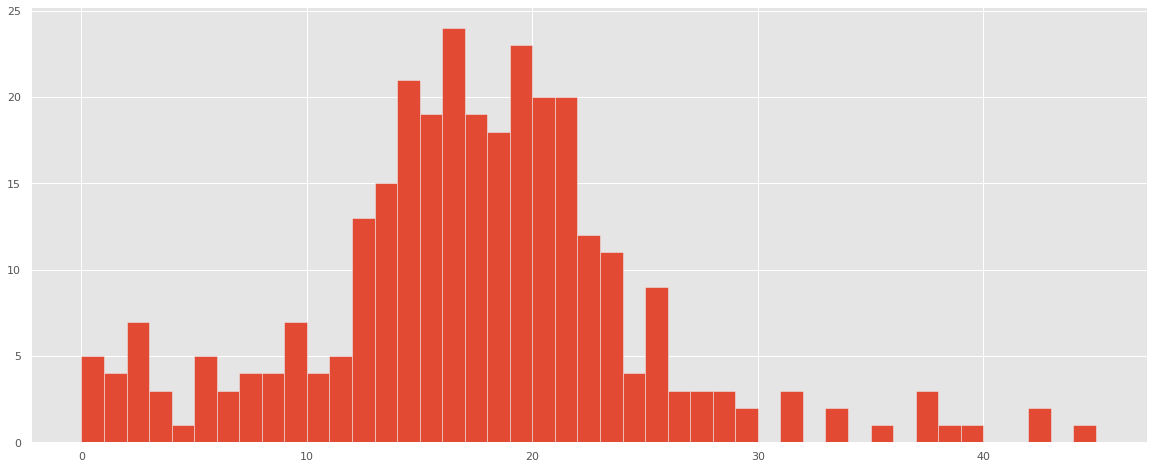

In [14]:
#data = merged_df[merged_df['ligado'] == True]['dia_semana']
plt.hist(start_end['duration'], np.arange(0,max(start_end['duration'])))

###### Criando Dataset sequencial

In [15]:
train = train[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora', 'timestamp', 'ligado']]

In [16]:
colunas = train.columns.tolist()
train_scaled = pd.DataFrame(np.append(
    preprocessing.scale(train[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora', 'timestamp']]), train[['ligado']].values, axis=1),
                            index=train.index, columns=train.columns)
train_scaled.head()

/home/tokyo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,voltage_mains,pwr_app_mains,pwr_act_mains,dia_semana,hora,timestamp,ligado
time,,,,,,,
2013-03-17 19:12:47,-1.390753,0.085978,0.008954,1.5511,1.077981,-1.732683,0.0
2013-03-17 19:12:53,-1.514176,0.083914,0.006935,1.5511,1.077981,-1.732679,0.0
2013-03-17 19:12:59,-1.658862,0.083299,0.006520,1.5511,1.077981,-1.732675,0.0
2013-03-17 19:13:05,-1.488636,0.086843,0.009948,1.5511,1.077981,-1.732671,0.0
2013-03-17 19:13:11,-1.076891,0.086545,0.009925,1.5511,1.077981,-1.732667,0.0


In [17]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

In [21]:
dev = "cpu"

In [13]:
device = torch.device(dev) 

class MyDataset(Dataset):
    def __init__(self, data, image_size, target_cols):
        self.data = torch.from_numpy(data).to(device)
        self.image_size = image_size
        self.target_cols = target_cols
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index:index+self.image_size, 0:self.target_cols]
        y = self.data[index:index+self.image_size, self.target_cols]
        return x, y
 
    def __len__(self):
        return len(self.data)
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [14]:
image_size = 48

In [15]:
batch_size = 64
target_cols = 6
 
dataset = MyDataset(train_scaled.values, image_size, target_cols)
#dataset = MyDataset(train.values, batch_size, target_cols)
 
trainloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

In [45]:
dataiter = iter(trainloader)

while True:
    x, y = dataiter.next()
    if torch.max(y) ==1:
        break
        
x, y = dataiter.next()

x = torch.transpose(x,1,2)

In [44]:
print(y[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)


In [43]:
saida_zero = net(x.float())
print(saida_zero[0])

tensor([-2.1193, -2.3141, -2.5323, -2.6743, -2.9108, -2.9844, -3.0543, -3.1243,
        -3.0646, -2.9281, -3.0591, -2.7805, -2.8196, -2.6988, -2.5116, -2.7973,
        -2.7523, -2.6258, -2.6073, -2.4206, -2.3108, -2.0868, -2.0722, -2.0837,
        -1.8525, -1.7593, -1.8877, -1.5545, -1.4313, -1.2796, -1.4640, -1.4614,
        -1.3890, -1.4002, -1.5525, -1.5948, -1.6546, -1.8111, -1.8408, -1.8687,
        -1.8585, -1.8510, -1.6724, -1.6879, -1.7206, -1.6284, -1.6269, -1.5944],
       device='cuda:0', grad_fn=<SelectBackward>)


In [46]:
print(y[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       dtype=torch.float64)


In [47]:
saida_um = net(x.float())
print(saida_um[0])

tensor([-3.6004, -3.7528, -4.3563, -4.6218, -5.0199, -4.8916, -5.1744, -5.2026,
        -5.7552, -5.6680, -5.6513, -5.6801, -5.2175, -4.8377, -5.4219, -5.0615,
        -4.7514, -4.7007, -4.3876, -4.3251, -3.7917, -3.0136, -2.5505, -2.0117,
        -1.4427, -0.8241, -0.4070,  0.0127,  0.5442,  0.8004,  1.1388,  1.2764,
         1.3566,  1.5804,  1.4989,  1.5674,  1.6111,  1.3479,  1.0820,  1.0528,
         0.9641,  0.8104,  0.5497,  0.3717,  0.1321, -0.1501, -0.3333, -0.5309],
       device='cuda:0', grad_fn=<SelectBackward>)


In [91]:
torch.sigmoid(saida_um[0])

tensor([0.0266, 0.0229, 0.0127, 0.0097, 0.0066, 0.0075, 0.0056, 0.0055, 0.0032,
        0.0034, 0.0035, 0.0034, 0.0054, 0.0079, 0.0044, 0.0063, 0.0086, 0.0090,
        0.0123, 0.0131, 0.0221, 0.0468, 0.0724, 0.1180, 0.1911, 0.3049, 0.3996,
        0.5032, 0.6328, 0.6901, 0.7575, 0.7818, 0.7952, 0.8293, 0.8174, 0.8274,
        0.8336, 0.7938, 0.7469, 0.7413, 0.7239, 0.6922, 0.6341, 0.5919, 0.5330,
        0.4625, 0.4174, 0.3703], device='cuda:0', grad_fn=<SigmoidBackward>)

# PYTORCH

pool1 = nn.MaxPool1d(5,1).to(device)
cv1 = nn.Conv1d(6, 6*8, 3).to(device)
cv2 = nn.Conv1d(6*8, 6*8, 3).to(device)
cv3 = nn.Conv1d(6*8, 16*6, 3).to(device)
cv4 = nn.Conv1d(16*6, 16*6, 3).to(device)
cv5 = nn.Conv1d(16*6, 32*6, 3).to(device)     
cv6 = nn.Conv1d(32*6, 32*6, 3).to(device)
cv7 = nn.Conv1d(32*6, 64*6, 3).to(device)
cv8 = nn.Conv1d(64*6, 64*6, 3).to(device)
fc1 = nn.Linear(64*6*8, 100).to(device)
fc2 = nn.Linear(100, 48).to(device)

o1 = cv2(cv2(cv1(x.float())))
o2 = pool1(o1)
o3 = cv4(cv4(cv3(o2)))
o4 = pool1(o3)
o5 = cv6(cv6(cv5(o4)))
o6 = pool1(o5)
o7 = cv8(cv8(cv7(o6)))
o8 = pool1(o7)
print(o8.shape)
o9 = fc1(o8.reshape(o8.size(0), -1))


print(o1.shape)
print(o2.shape)
print(o3.shape)
print(o7.shape)
print(o8.shape)

In [16]:
class Net(nn.Module):    
      def __init__(self):
        super(Net, self).__init__()
        self.pool1 = nn.MaxPool1d(5,1)
        self.cv1 = nn.Conv1d(6, 6*8, 3)
        self.cv2 = nn.Conv1d(6*8, 6*8, 3)
        self.cv3 = nn.Conv1d(6*8, 6*8, 3)
        self.cv4 = nn.Conv1d(6*8, 16*6, 3)
        self.cv5 = nn.Conv1d(16*6, 16*6, 3)
        self.cv6 = nn.Conv1d(16*6, 16*6, 3)
        self.cv7 = nn.Conv1d(16*6, 32*6, 3)       
        self.cv8 = nn.Conv1d(32*6, 32*6, 3)
        self.cv9 = nn.Conv1d(32*6, 32*6, 3)
        self.cv10 = nn.Conv1d(32*6, 64*6, 3)
        self.cv11 = nn.Conv1d(64*6, 64*6, 3)
        self.cv12 = nn.Conv1d(64*6, 64*6, 3)
        self.fc1 = nn.Linear(64*6*8, 300)
        self.fc2 = nn.Linear(300, image_size)
        self.bn = nn.BatchNorm1d(64*6)
        self.dropout = nn.Dropout(p=0.5)
        
      def forward(self, x):
        x = F.relu(self.cv3(F.relu(self.cv2(F.relu(self.cv1(x))))))
        #x = self.dropout(x)
        x = self.pool1(x)
        x = F.relu(self.cv6(F.relu(self.cv5(F.relu(self.cv4(x))))))
        #x = self.dropout(x)
        x = self.pool1(x)
        x = F.relu(self.cv9(F.relu(self.cv8(F.relu(self.cv7(x))))))
        #x = self.dropout(x)
        x = self.pool1(x)
        x = F.relu(self.cv12(F.relu(self.cv11(F.relu(self.cv10(x))))))
        x = self.bn(x)
        x = self.pool1(x)
        x = F.relu(self.fc1(x.reshape(x.size(0), -1)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if type(m) == nn.Conv1d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01) 

net = Net()
net = net.to(device)
net.apply(init_weights)
print(net)

Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(6, 48, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(48, 48, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(48, 48, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(48, 96, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(96, 96, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(96, 96, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(96, 192, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(192, 192, kernel_size=(3,), stride=(1,))
  (cv9): Conv1d(192, 192, kernel_size=(3,), stride=(1,))
  (cv10): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
  (cv11): Conv1d(384, 384, kernel_size=(3,), stride=(1,))
  (cv12): Conv1d(384, 384, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=3072, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=48, bias=True)
  (bn): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=

In [17]:
criterion = nn.BCEWithLogitsLoss()

#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
net.zero_grad()

In [19]:
comeco = datetime.datetime.now()
for epoch in range(5):  # loop over the dataset multiple times

    real_i = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i > len(trainloader)-image_size:
            break
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.to(device)
        if torch.max(labels).item() == 0:
            continue     
                
        inputs = torch.transpose(inputs,1,2)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizepadded input size per channel: 
        outputs = net(inputs.float())

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        real_i += 1
        
        # print statistics
        running_loss += loss.item()
        if real_i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, real_i + 1, running_loss / 100))
            running_loss = 0.0

duracao = datetime.datetime.now() - comeco
print('Finished Training', duracao)

[1,   100] loss: 0.430
[1,   200] loss: 0.337
[1,   300] loss: 0.330
[1,   400] loss: 0.313
[1,   500] loss: 0.279
[2,   100] loss: 0.270
[2,   200] loss: 0.269
[2,   300] loss: 0.311
[2,   400] loss: 0.276
[2,   500] loss: 0.231
[3,   100] loss: 0.247
[3,   200] loss: 0.231
[3,   300] loss: 0.238
[3,   400] loss: 0.289
[3,   500] loss: 0.217
[4,   100] loss: 0.240
[4,   200] loss: 0.235
[4,   300] loss: 0.238
[4,   400] loss: 0.226
[4,   500] loss: 0.178
[5,   100] loss: 0.234
[5,   200] loss: 0.231
[5,   300] loss: 0.261
[5,   400] loss: 0.230
[5,   500] loss: 0.166
Finished Training 0:08:18.982406


In [20]:
torch.save(net, '/home/tokyo/Desktop/TCC/saved_models/BCEwithlogits_CNN_kettle_poucos_dados_dropout0.75_batchnorm_v1.pt')

In [24]:
net = torch.load('/home/tokyo/Desktop/TCC/saved_models/BCEwithlogits_CNN_kettle_poucos_dados_batchnorm_v1.pt', map_location=device)
net.eval()

Net(
  (pool1): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cv1): Conv1d(6, 48, kernel_size=(3,), stride=(1,))
  (cv2): Conv1d(48, 48, kernel_size=(3,), stride=(1,))
  (cv3): Conv1d(48, 96, kernel_size=(3,), stride=(1,))
  (cv4): Conv1d(96, 96, kernel_size=(3,), stride=(1,))
  (cv5): Conv1d(96, 192, kernel_size=(3,), stride=(1,))
  (cv6): Conv1d(192, 192, kernel_size=(3,), stride=(1,))
  (cv7): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
  (cv8): Conv1d(384, 384, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=3072, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=48, bias=True)
  (bn): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.75, inplace=False)
)

# Teste

In [85]:
test = test[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora', 'timestamp', 'ligado']]
colunas = test.columns.tolist()
test_scaled = pd.DataFrame(np.append(
    preprocessing.scale(test[['voltage_mains', 'pwr_app_mains', 'pwr_act_mains', 'dia_semana', 'hora', 'timestamp']]), test[['ligado']].values, axis=1),
                            index=test.index, columns=test.columns)
test_scaled.head()

batch_size = 64
target_cols = 6
 
test_dataset = MyDataset(test_scaled.values, image_size, target_cols) 
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

In [86]:
test['saidas'] = 0.0

In [87]:
len(test)

216454

In [88]:
net.eval()

comeco = datetime.datetime.now()
print(comeco)

array = test.iloc[:, 7].values

array_results = []

for i, data in enumerate(testloader, 0):
    
    if i > len(testloader)-image_size:
        break
        
    if i % 10000 == 9999:
        print(i + 1)
        print(datetime.datetime.now() - comeco)
        
    inputs, labels = data
    inputs = torch.transpose(inputs,1,2)
  
    out = net(inputs.float())
    
    out = torch.sigmoid(out)
      
#     array[i:i+image_size] += out[0].detach().cpu().numpy()
    for element in out:
        array_results.append(element.detach().cpu().numpy())
        
for i, element in enumerate(array_results):
    array[i:i+image_size] += element
    
test.iloc[:, 7] = array

duracao = datetime.datetime.now() - comeco
print(duracao)

2021-02-23 00:03:25.261889
0:06:31.883272


In [38]:
test.to_csv('saidas_conv_kettle_poucos_dados_droupout075_batchnorm_v1.csv', sep=',', header=True, index=True)

In [24]:
test.head()

,voltage_mains,pwr_app_mains,pwr_act_mains,dia_semana,hora,timestamp,ligado,saidas
time,,,,,,,,
2013-05-16 23:14:35,241.266663,236.711670,156.578339,3,23,1.368746e+09,False,-3.690356
2013-05-16 23:14:41,241.913330,236.838333,157.014999,3,23,1.368746e+09,False,-7.814937
2013-05-16 23:14:47,241.968323,236.854996,157.151672,3,23,1.368746e+09,False,-12.569944
2013-05-16 23:14:53,241.888336,237.546661,157.456665,3,23,1.368746e+09,False,-17.835052
2013-05-16 23:14:59,241.853333,237.041672,157.193329,3,23,1.368746e+09,False,-23.696241


In [25]:
test["ligado"] = test["ligado"].astype(int)

In [69]:
test.iloc[:, 7] = array

In [80]:
test['ligado'] = test['ligado'].apply(lambda x: x*40)

In [57]:
test['saidas'] = test['saidas'].apply(lambda x: x if x > 0 else 0)

In [61]:
test[test['ligado'] == 1].describe()

,voltage_mains,pwr_app_mains,pwr_act_mains,dia_semana,hora,timestamp,ligado,saidas
count,775.000000,775.000000,775.000000,775.000000,775.000000,7.750000e+02,775.0,775.000000
mean,241.992844,2676.012207,2652.424316,3.365161,12.810323,1.369081e+09,1.0,590.891794
std,1.459767,643.839417,652.946228,2.200440,4.532558,2.904079e+05,0.0,1397.024377
min,236.868332,196.710007,144.663330,0.000000,5.000000,1.368777e+09,1.0,0.000000
25%,241.102501,2617.069214,2599.229980,1.000000,8.000000,1.368913e+09,1.0,8.800029
50%,241.971664,2697.294922,2678.626709,4.000000,13.000000,1.368992e+09,1.0,134.958089
75%,242.931664,2803.652588,2783.515869,5.000000,17.000000,1.369143e+09,1.0,284.600643
max,246.464996,4443.813477,4408.353516,6.000000,21.000000,1.370031e+09,1.0,10556.543286


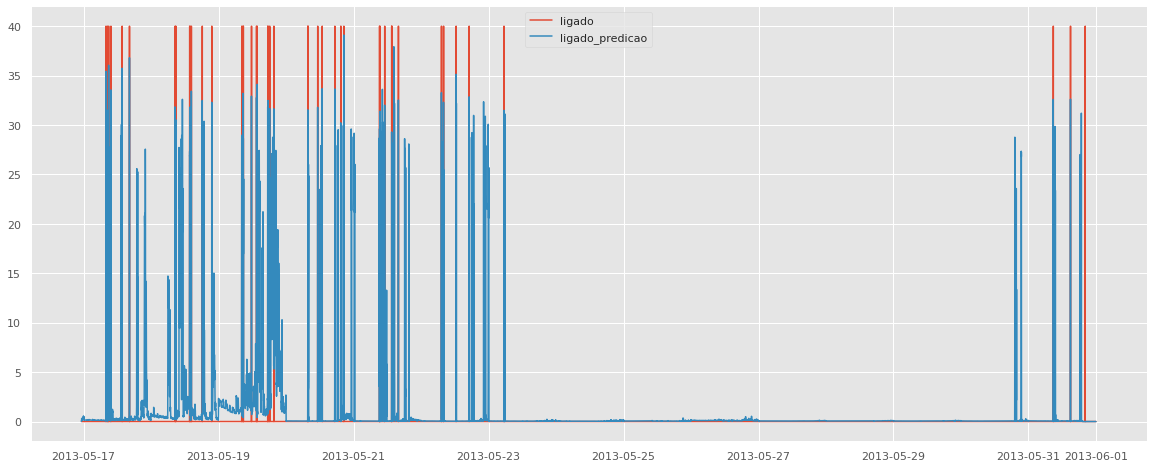

In [90]:
plt.plot(test.index, test['ligado'], label = 'ligado')
plt.plot(test.index, test['saidas'], label = "ligado_predicao")
plt.legend()
plt.show()

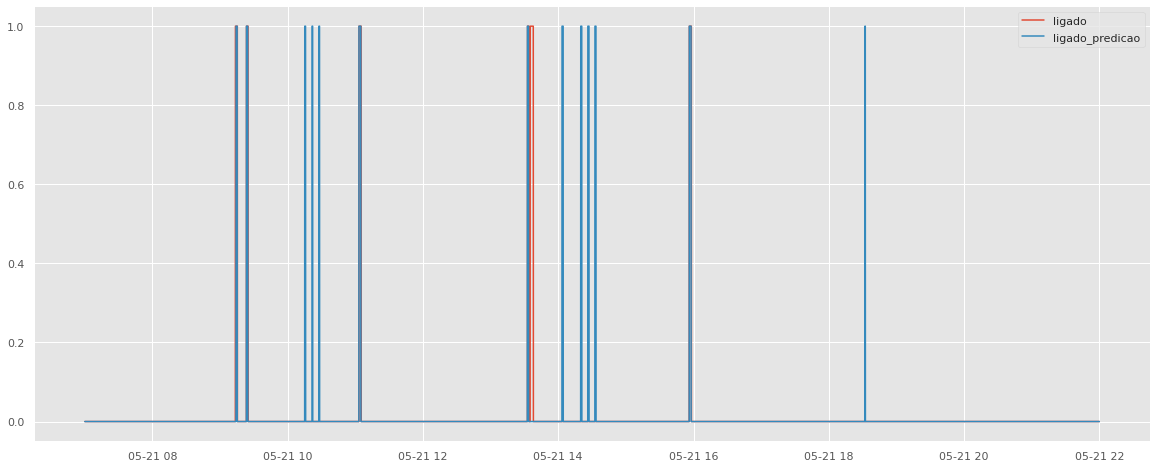

In [53]:
# datetime(year, month, day, hour, minute, second, microsecond)
date_from = datetime.datetime(2013, 5, 21, 7)
date_to = datetime.datetime(2013, 5, 21, 22)

test_detail_plot = test[(test.index > date_from) & (test.index < date_to)]

plt.plot(test_detail_plot.index, test_detail_plot['ligado'], label = 'ligado')
plt.plot(test_detail_plot.index, test_detail_plot['saidas'], label = 'ligado_predicao')
plt.legend()
plt.show()

In [76]:
y = test.iloc[:,6].values
y_pred = test.iloc[:,7].values

TP = 0
TN = 0
FP = 0
FN = 0
P = 0
N = 0

for i in range(len(y)):
    if y_pred[i] == y[i]:
        if y_pred[i] == True:
            TP += 1
            P += 1
        else:
            TN += 1
            N += 1
    else:
        if y_pred[i] == True:
            FP += 1
            N += 1
        else:
            FN += 1
            P += 1
    
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TP+TN)/(P+N)
f1 = 2*(precision*recall)/(precision+recall)
    
print("True Positives: " + str(TP))
print("True Negatives: " + str(TN))
print("False Positives: " + str(FP))
print("False Negatives: " + str(FN))
print("Positives: " + str(P))
print("Negatives: " + str(N))
print("-----------------------------")
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("Accuracy: " + str(accuracy))
print("F1 score: " + str(TP/(TP+FP)))

True Positives: 390
True Negatives: 215457
False Positives: 222
False Negatives: 385
Positives: 775
Negatives: 215679
-----------------------------
Recall: 0.5032258064516129
Precision: 0.6372549019607843
Accuracy: 0.9971957090190063
F1 score: 0.6372549019607843


# Dropout 0.2 cada camada, todas conv diferentes
True Positives: 448
True Negatives: 215492
False Positives: 187
False Negatives: 327
Positives: 775
Negatives: 215679

-----------------------------
Recall: 0.5780645161290323
Precision: 0.705511811023622
Accuracy: 0.9976253615086809
F1 score: 0.705511811023622
